# Multi-Class Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7,4)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv('iris.csv')

In [3]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Exploratory Data Analysis and Visualization

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


In [6]:
df['species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

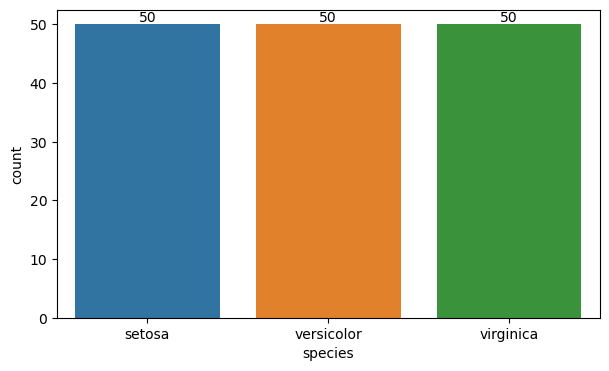

In [7]:
ax = sns.countplot(data = df, x ='species')
ax.bar_label(ax.containers[0]);

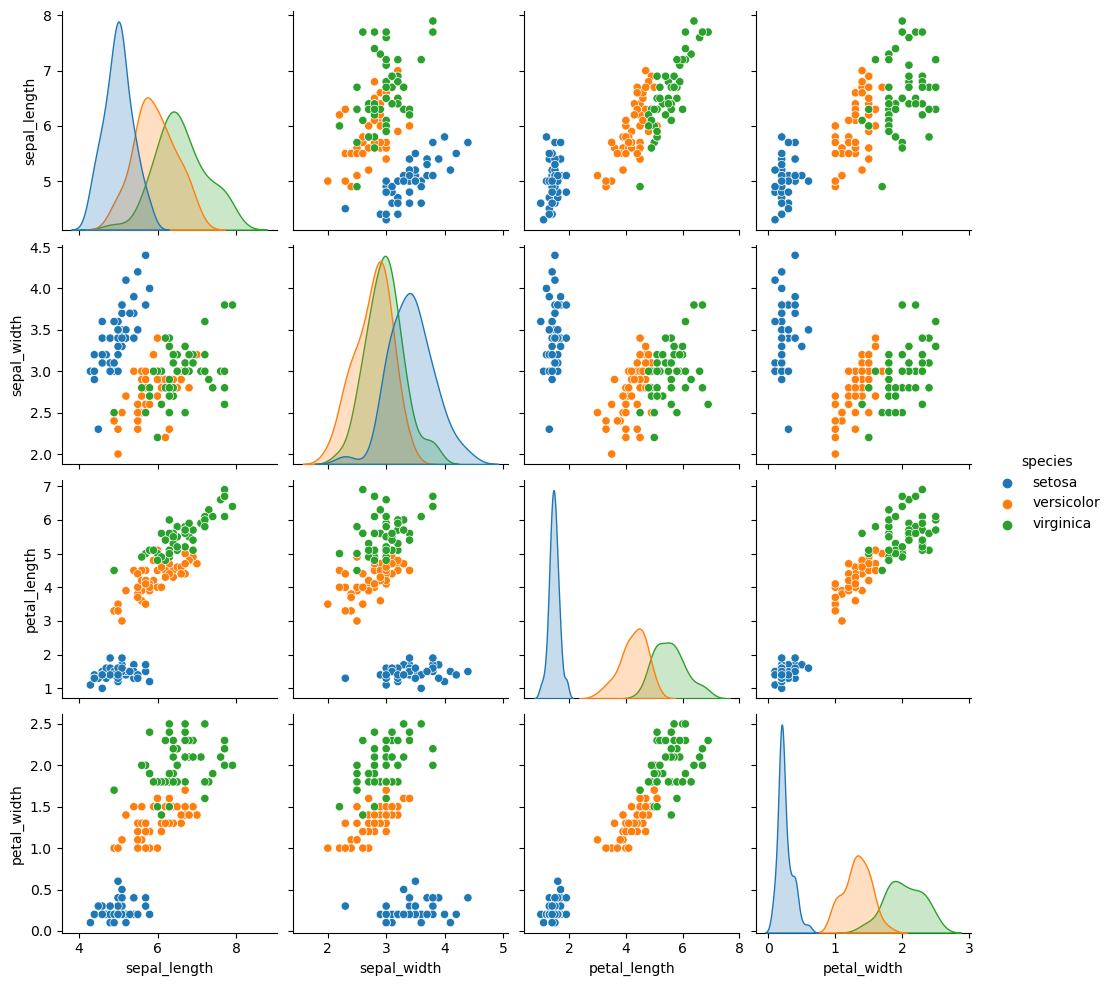

In [8]:
sns.pairplot(df,hue='species');

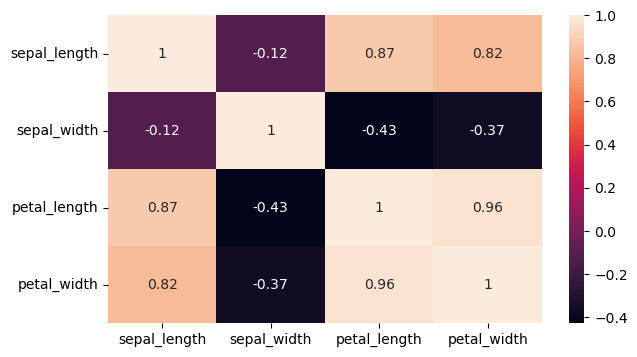

In [9]:
sns.heatmap(df.corr(),annot=True);

## Train | Test Split and Modeling

In [10]:
X = df.drop('species',axis=1)
y = df['species']

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

# stratify=y datanız imbalanced da olsa balanced da olsa kullanabilirsiniz. Ama imbalanced datalarda mutlaka kullanmalısınız
# datam balanced olduğundan burda kullanma gereği duymadık.

In [13]:
operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression())]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression())])

## Model Performance

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

### With Default Parameters

In [15]:
y_pred = pipe_model.predict(X_test)
y_pred

# targetımız numeric veri olabileceği gibi object veride olabilir. Target ikisini de kabul eder. 

array(['setosa', 'setosa', 'setosa', 'virginica', 'versicolor',
       'virginica', 'versicolor', 'versicolor', 'virginica', 'setosa',
       'virginica', 'setosa', 'setosa', 'virginica', 'virginica',
       'versicolor', 'versicolor', 'versicolor', 'setosa', 'versicolor',
       'versicolor', 'setosa', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'virginica', 'setosa', 'setosa'],
      dtype=object)

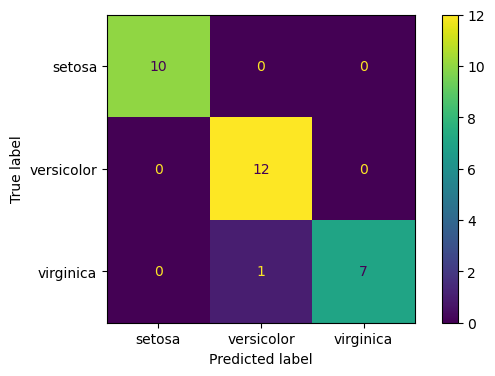

In [16]:
ConfusionMatrixDisplay.from_estimator(pipe_model, X_test, y_test);

In [17]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [18]:
eval_metric(pipe_model, X_train, y_train, X_test, y_test)

Test_Set
[[10  0  0]
 [ 0 12  0]
 [ 0  1  7]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.92      1.00      0.96        12
   virginica       1.00      0.88      0.93         8

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30


Train_Set
[[40  0  0]
 [ 0 35  3]
 [ 0  1 41]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        40
  versicolor       0.97      0.92      0.95        38
   virginica       0.93      0.98      0.95        42

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



### Cross Validate

In [19]:
from sklearn.model_selection import cross_validate

operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression())]

model = Pipeline(steps=operations)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision_weighted','recall_weighted',
                                                                   'f1_weighted'], cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# multiclass datalarda CV veya gridsearchCV için precision, recall ve f1 metriclerini tek başına kullanmayız. Yukarda olduğu
# gibi precision_weighted, precision_macro, precision_micro vb. yazmalıyız. Yoksa hata alırsınız. Spesifik olarak tek bir 
# sınıfa ait CV scorlarını görmek istiyorsak aşağıda gösterildiği gibi make_scorer fonksiyonunu kullanmalıyız.

test_accuracy               0.950000
train_accuracy              0.963889
test_precision_weighted     0.960000
train_precision_weighted    0.964076
test_recall_weighted        0.950000
train_recall_weighted       0.963889
test_f1_weighted            0.949206
train_f1_weighted           0.963872
dtype: float64

### Cross Validate for versicolar

In [20]:
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score


f1_versicolor = make_scorer(f1_score, average = None, labels =["versicolor"])
precision_versicolor = make_scorer(precision_score, average = None, labels =["versicolor"])
recall_versicolor = make_scorer(recall_score, average = None, labels =["versicolor"])


scoring = {"f1_versicolor":f1_versicolor, 
           "precision_versicolor":precision_versicolor,
           "recall_versicolor":recall_versicolor}

# Multiclass datalarda hedef labelınız ne ise onun üzerinden CV scorlarını alabilirsiniz. 
# Yine make_scorer fonksiyonunu kullanamk zorundayız. Data multi class olduğunda make_scorer fonksiyonu içine average, ve labels
# parametreleri mutlaka belirtilmelidir.

In [22]:
# f1_score()

In [23]:
operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression())]
model = Pipeline(steps=operations)

scores = cross_validate(model, X_train, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# overfiting olmadığını gördük

test_f1_versicolor            0.923810
train_f1_versicolor           0.942656
test_precision_versicolor     0.940000
train_precision_versicolor    0.949885
test_recall_versicolor        0.925000
train_recall_versicolor       0.935798
dtype: float64

## Class prediction

In [24]:
y_pred=pipe_model.predict(X_test)
y_pred_proba = pipe_model.predict_proba(X_test)

test_data = pd.concat([X_test, y_test], axis=1)
test_data["pred"] = y_pred
test_data["pred_proba_setosa"] = y_pred_proba[:,0]
test_data["pred_proba_versicolar"] = y_pred_proba[:,1]
test_data["pred_proba_virginica"] = y_pred_proba[:,2]
test_data.sample(10)

# multiclass datalarda 0.5 thresholdu aranmaz. Hangi classa ait olasılık yüksek ise o sınıfa atanır.

,sepal_length,sepal_width,petal_length,petal_width,species,pred,pred_proba_setosa,pred_proba_versicolar,pred_proba_virginica
42,4.4,3.2,1.3,0.2,setosa,setosa,0.984541,0.015459,2.471313e-07
53,5.5,2.3,4.0,1.3,versicolor,versicolor,0.008192,0.886796,1.050119e-01
41,4.5,2.3,1.3,0.3,setosa,setosa,0.575675,0.424300,2.461582e-05
134,6.1,2.6,5.6,1.4,virginica,versicolor,0.001277,0.511730,4.869928e-01
1,4.9,3.0,1.4,0.2,setosa,setosa,0.913848,0.086150,1.814027e-06
65,6.7,3.1,4.4,1.4,versicolor,versicolor,0.013994,0.874942,1.110645e-01
50,7.0,3.2,4.7,1.4,versicolor,versicolor,0.009149,0.851715,1.391362e-01
25,5.0,3.0,1.6,0.2,setosa,setosa,0.882397,0.117600,3.147888e-06
127,6.1,3.0,4.9,1.8,virginica,virginica,0.005718,0.389264,6.050179e-01
48,5.3,3.7,1.5,0.2,setosa,setosa,0.986904,0.013096,1.546878e-07


In [ ]:
# y_pred_proba

### With Best Parameters (GridsearchCV)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [25]:
operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression(max_iter=5000))]
 
model = Pipeline(steps=operations)

In [26]:
model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('logistic', LogisticRegression(max_iter=5000))],
 'verbose': False,
 'scaler': StandardScaler(),
 'logistic': LogisticRegression(max_iter=5000),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'logistic__C': 1.0,
 'logistic__class_weight': None,
 'logistic__dual': False,
 'logistic__fit_intercept': True,
 'logistic__intercept_scaling': 1,
 'logistic__l1_ratio': None,
 'logistic__max_iter': 5000,
 'logistic__multi_class': 'auto',
 'logistic__n_jobs': None,
 'logistic__penalty': 'l2',
 'logistic__random_state': None,
 'logistic__solver': 'lbfgs',
 'logistic__tol': 0.0001,
 'logistic__verbose': 0,
 'logistic__warm_start': False}

In [27]:
penalty = ["l1", "l2"]
C = [0.01, 0.1, 1, 5, 16, 19, 22, 25]

param_grid = {"logistic__penalty" : penalty,
             "logistic__C" : C}

In [28]:
grid_model = GridSearchCV(model, param_grid = param_grid, cv=5, return_train_score=True) 

#scoring = f1_versicolor = make_scorer(f1_score, average = None, labels =["versicolor"]) 

# scoring clasification datalarında default olarak accuracy'dir. Eğer özellikle bir sınıfa ait metriclerin iyileştirilmesini
# istiyorsak yukarıda scoring parametresi olarak make_scorer fonksiyonunu tanımlamalıyız.

# Eğer modelin versicolor classının f1_scorunu iyileştirecek şekilde en iyi paramatreleri bulmasını isteseydik,
# scoring = make_scorer(f1_score, average = None, labels =["versicolor"]) olarak düzenlemeliydik.

In [30]:
grid_model.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(max_iter=5000))]),
             param_grid={'logistic__C': [0.01, 0.1, 1, 5, 16, 19, 22, 25],
                         'logistic__penalty': ['l1', 'l2']},
             return_train_score=True)

In [31]:
grid_model.best_params_

{'logistic__C': 19, 'logistic__penalty': 'l2'}

In [32]:
grid_model.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression(C=19, max_iter=5000))])

In [33]:
pd.DataFrame(grid_model.cv_results_).loc[grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

mean_test_score       0.975
mean_train_score    0.98125
Name: 11, dtype: object

In [34]:
y_pred = grid_model.predict(X_test)
y_pred

array(['setosa', 'setosa', 'setosa', 'virginica', 'versicolor',
       'virginica', 'versicolor', 'versicolor', 'virginica', 'setosa',
       'virginica', 'setosa', 'setosa', 'virginica', 'virginica',
       'versicolor', 'versicolor', 'versicolor', 'setosa', 'virginica',
       'versicolor', 'setosa', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'virginica', 'setosa', 'setosa'],
      dtype=object)

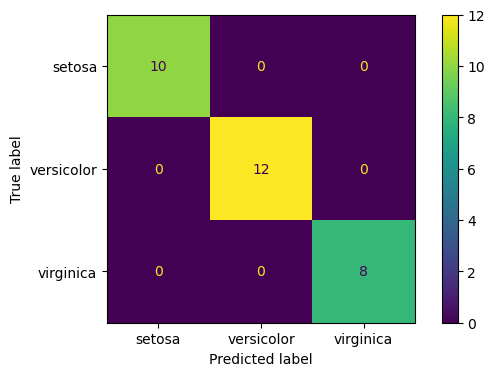

In [35]:
ConfusionMatrixDisplay.from_estimator(grid_model, X_test, y_test);

In [36]:
eval_metric(grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[10  0  0]
 [ 0 12  0]
 [ 0  0  8]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        12
   virginica       1.00      1.00      1.00         8

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Train_Set
[[40  0  0]
 [ 0 37  1]
 [ 0  1 41]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        40
  versicolor       0.97      0.97      0.97        38
   virginica       0.98      0.98      0.98        42

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

In [37]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

In [38]:
RocCurveDisplay.from_estimator(grid_model, X_test, y_test);

# PrecisionRecallDisplay.from_estimator(grid_model, X_test, y_test);

# RocCurveDisplay veya PrecisionRecallDisplay multiclass datalar için çalışmaz. Hata verir.

ValueError: Expected 'estimator' to be a binary classifier, but got GridSearchCV fit on multiclass (3 classes) data

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [ ]:
# conda install -c conda-forge scikit-plot

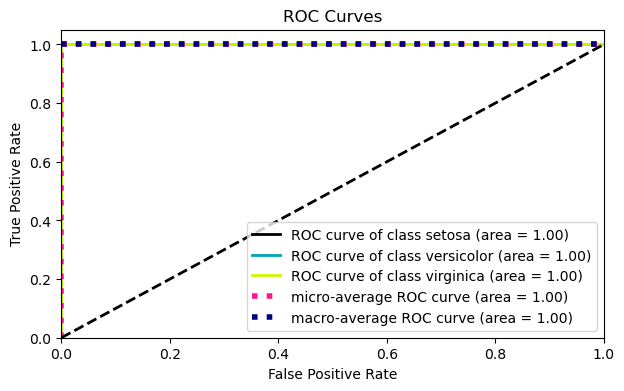

In [39]:
from scikitplot.metrics import plot_roc, precision_recall_curve
from scikitplot.metrics import plot_precision_recall


operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression(C=19, max_iter=5000))]

model = Pipeline(steps=operations)

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
    
plot_roc(y_test, y_pred_proba)
plt.show();

In [46]:
from sklearn.metrics import average_precision_score, roc_auc_score

y_test_dummies = pd.get_dummies(y_test).values

roc_auc_score(y_test_dummies[:, 1], y_pred_proba[:, 1])  # roc_auc score  for versicolor

1.0

In [47]:
y_test[:5]

33         setosa
16         setosa
43         setosa
129     virginica
50     versicolor
Name: species, dtype: object

In [48]:
y_test_dummies[:5]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

## Precision Recall Curve

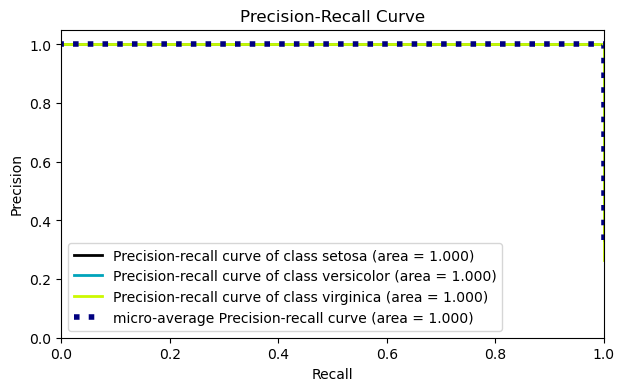

In [49]:
from scikitplot.metrics import plot_roc, precision_recall_curve
from scikitplot.metrics import plot_precision_recall


operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression(C=19, max_iter=5000))]

model = Pipeline(steps=operations)

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
    
plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [50]:
from sklearn.metrics import average_precision_score, roc_auc_score

y_test_dummies = pd.get_dummies(y_test).values

average_precision_score(y_test_dummies[:, 1], y_pred_proba[:, 1])  # average precision score for versicolor

1.0

## Final Model and Model Deployment

In [51]:
operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression())]

final_model = Pipeline(steps=operations)

final_model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression())])

In [52]:
import pickle
pickle.dump(final_model, open("final_pipe_model", 'wb'))

In [53]:
new_model = pickle.load(open("final_pipe_model", "rb"))

In [54]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


In [55]:
my_dict = {"sepal_length": [4.5, 5.8, 7.5],
           "sepal_width": [2.2, 3, 4.2],
           "petal_length": [1.3, 4.3, 6.5],
           "petal_width": [0.2, 1.3, 2.3]
          }

In [56]:
sample = pd.DataFrame(my_dict)
sample

,sepal_length,sepal_width,petal_length,petal_width
0,4.5,2.2,1.3,0.2
1,5.8,3.0,4.3,1.3
2,7.5,4.2,6.5,2.3


In [57]:
predictions = final_model.predict(sample)
predictions_proba = final_model.predict_proba(sample)

In [58]:
sample["pred"] = predictions
sample["pred_proba_setosa"] = predictions_proba[:,0]
sample["pred_proba_versicolor"] = predictions_proba[:,1]
sample["pred_proba_virginica"] = predictions_proba[:,2]
sample

,sepal_length,sepal_width,petal_length,petal_width,pred,pred_proba_setosa,pred_proba_versicolor,pred_proba_virginica
0,4.5,2.2,1.3,0.2,setosa,0.712393,0.287603,0.000004
1,5.8,3.0,4.3,1.3,versicolor,0.044001,0.890134,0.065864
2,7.5,4.2,6.5,2.3,virginica,0.000085,0.020543,0.979372
